Initial results. Using jobid 53232482, model astroclip-epoch=03-min.ckpt

Conclusions / to do after analysing results of this model:
- The model only takes 3 epochs to reach the lowest validation loss, which is interesting. The validation loss just fluctuates and doesn't really go down. Why is the model struggling to generalise?
- The plots exclude redshifts outside the range [0, 0.8]. This is the range that the spender model was pre-trained on. The model is likely to perform better if I start the training without these redshifts.

In [5]:
import numpy as np
from astroclip.utils import load_config, download_desi_dataset
from astroclip.transforms import Permute, NormaliseSpectrum, Squeeze
from astroclip.blocks import SpectrumEncoderSpender
from astroclip.models import ContrastiveBimodalPretraining
import torch
import torch.nn as nn
from torchvision.transforms import CenterCrop
from pl_bolts.models.self_supervised import Moco_v2
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [6]:
config = load_config('local')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

dataset = download_desi_dataset(cache_dir)

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
# Define all the image and spectrum transforms / augmentations
image_transforms = nn.Sequential(
    Permute([0, 3, 1, 2]),  # Change to [batch_size, channel, npix, npix]
    CenterCrop(96)
)

In [10]:
lambda_min = 3600.0  # Minimum wavelength in Angstroms, in observed spectra
lambda_max = 9824.0
z_max = 0.8
restframe_wavelengths = torch.linspace(lambda_min / (1 + z_max), lambda_max, 7781)

spectrum_transforms = nn.Sequential(
    Permute([0, 2, 1]),  # Change to [batch_size, channel, spectrum_length]
    NormaliseSpectrum(restframe_wavelengths, (5300, 5850)),
    Squeeze(1)
)

In [11]:
spectrum_encoder = SpectrumEncoderSpender(
    state_dict=torch.load(f'{cache_dir}/spender.desi-edr.encoder.pth'),
    mlp=nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 128)),
)

image_model = Moco_v2.load_from_checkpoint(f'{cache_dir}/resnet50.ckpt')
image_encoder = image_model.encoder_q

jobid = '53232482'
model_name = 'astroclip-epoch=03-min.ckpt'

model = ContrastiveBimodalPretraining.load_from_checkpoint(
    f'{output_dir}/astroclip_ckpt_{jobid}/{model_name}',
    encoders=[image_encoder, spectrum_encoder],
    strict=False
)

image_encoder = model.mod1_encoder
spectrum_encoder = model.mod2_encoder

Lightning automatically upgraded your loaded checkpoint from v1.6.2 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../cache/resnet50.ckpt`
/Users/adnansiddiquei/miniconda3/envs/astroclip_env/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature Moco_v2 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
/Users/adnansiddiquei/miniconda3/envs/astroclip_env/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:255: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['mod2_pre_transforms.1.restframe_wavelengths']
  rank_zero_warn(


In [12]:
train_loader = DataLoader(
    dataset['train'],
    batch_size=config['astroclip']['batch_size'],
    drop_last=True,
)

val_loader = DataLoader(
    dataset['test'],
    batch_size=config['astroclip']['batch_size'],
    drop_last=True,
)

In [13]:
spectrum_embeddings = np.empty((0, 128))
image_embeddings = np.empty((0, 128))
redshifts = np.array([])

spectrum_encoder = spectrum_encoder.eval().to('mps')
image_encoder = image_encoder.eval().to('mps')

with torch.no_grad():
    for batch in tqdm(val_loader):
        spectrum = batch['spectrum'].to('mps')
        image = batch['image'].to('mps')
        
        spectrum = spectrum_transforms(spectrum)
        image = image_transforms(image)
        
        encoded_spectrum = spectrum_encoder(spectrum)
        encoded_image = image_encoder(image)
        
        spectrum_embeddings = np.concatenate([spectrum_embeddings, encoded_spectrum.cpu().numpy()], axis=0)
        image_embeddings = np.concatenate([image_embeddings, encoded_image.cpu().numpy()], axis=0)
        redshifts = np.concatenate([redshifts, batch['redshift'].numpy()])

100%|██████████| 154/154 [02:32<00:00,  1.01it/s]


In [39]:
pretrained_spectrum_embeddings = np.empty((0, 128))
pretrained_image_embeddings = np.empty((0, 128))
redshifts = np.array([])

pretrained_spectrum_encoder = SpectrumEncoderSpender(
    state_dict=torch.load(f'{cache_dir}/spender.desi-edr.encoder.pth'),
    mlp=nn.Sequential(nn.Linear(256, 128)),
).eval().to('mps')

pretrained_image_model = Moco_v2.load_from_checkpoint(f'{cache_dir}/resnet50.ckpt')
pretrained_image_encoder = pretrained_image_model.encoder_q.eval().to('mps')

with torch.no_grad():
    for batch in tqdm(val_loader):
        spectrum = batch['spectrum'].to('mps')
        image = batch['image'].to('mps')
        
        spectrum = spectrum_transforms(spectrum)
        image = image_transforms(image)
        
        encoded_spectrum = pretrained_spectrum_encoder(spectrum)
        encoded_image = pretrained_image_encoder(image)
        
        pretrained_spectrum_embeddings = np.concatenate(
            [pretrained_spectrum_embeddings, encoded_spectrum.cpu().numpy()], axis=0)
        
        pretrained_image_embeddings = np.concatenate(
            [pretrained_image_embeddings, encoded_image.cpu().numpy()], axis=0)
        
        redshifts = np.concatenate([redshifts, batch['redshift'].numpy()])

Lightning automatically upgraded your loaded checkpoint from v1.6.2 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../cache/resnet50.ckpt`
100%|██████████| 154/154 [02:41<00:00,  1.05s/it]


In [88]:
def predict_redshifts(embeddings: list[np.ndarray], redshifts, n_neighbours=16):
    """
    Predict redshift for the embeddings given in embeddings[0], using their closest neighbours in embeddings[1].
    """
    neighbours = NearestNeighbors(n_neighbors=n_neighbours, algorithm='auto').fit(embeddings[1])  
    distances, indices = neighbours.kneighbors(embeddings[0])
    predicted_redshifts = np.array([redshifts[indices[i]].mean() for i in range(len(embeddings[0]))])
    return predicted_redshifts

def plot_r2_score(ax, redshifts, predicted_redshifts, outlier_limits=(0, 0.8)):
    outlier_limit_upper = outlier_limits[1]
    outlier_limit_lower = outlier_limits[0]
    
    clean_indices = np.where((redshifts > outlier_limit_lower) & (redshifts < outlier_limit_upper))[0]
    
    outlier_count = len(redshifts) - len(clean_indices)
    
    print(f'Outlier count: {outlier_count} ({outlier_count*100/len(redshifts):.2f}%).')
    print(f'Total number of galaxies: {len(redshifts):,}')
    
    # Compute R^2 score
    r2 = r2_score(predicted_redshifts[clean_indices], redshifts[clean_indices])
    print(f'R² score: {r2:.2f}')
    
    ax.scatter(redshifts[clean_indices], predicted_redshifts[clean_indices], s=1)
    ax.set_xlim(-0.05, outlier_limit_upper + 0.05)
    ax.set_ylim(-0.05, outlier_limit_upper + 0.05)
    ax.plot(np.linspace(0, outlier_limit_upper, 100), np.linspace(0, outlier_limit_upper, 100), color='orange', linestyle='--')
    
    ax.set_xlabel('True redshift')
    ax.set_ylabel('Predicted redshift')
    ax.text(0.05, outlier_limit_upper - 0.1, rf'$R^2$ score = {r2:.2f}', fontsize=12)

In [51]:
ss_predicted_redshifts = predict_redshifts([spectrum_embeddings, spectrum_embeddings], redshifts)
ii_predicted_redshifts = predict_redshifts([image_embeddings, image_embeddings], redshifts)
si_predicted_redshifts = predict_redshifts([spectrum_embeddings, image_embeddings], redshifts)
is_predicted_redshifts = predict_redshifts([image_embeddings, spectrum_embeddings], redshifts)

In [ ]:
ss_pretrained_predicted_redshifts = predict_redshifts(
    [pretrained_spectrum_embeddings, pretrained_spectrum_embeddings], redshifts)
ii_pretrained_predicted_redshifts = predict_redshifts(
    [pretrained_image_embeddings, pretrained_image_embeddings], redshifts)
si_pretrained_predicted_redshifts = predict_redshifts(
    [pretrained_spectrum_embeddings, pretrained_image_embeddings], redshifts)
is_pretrained_predicted_redshifts = predict_redshifts(
    [pretrained_image_embeddings, pretrained_spectrum_embeddings], redshifts)

Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: 0.91
Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: 0.86


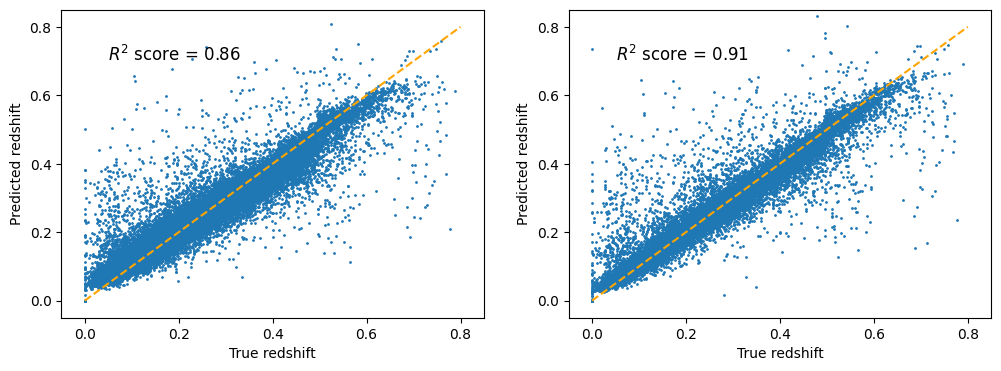

In [91]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plot_r2_score(ax[1], redshifts, ss_predicted_redshifts)
plot_r2_score(ax[0], redshifts, ss_pretrained_predicted_redshifts)

Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: 0.41
Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: -0.05


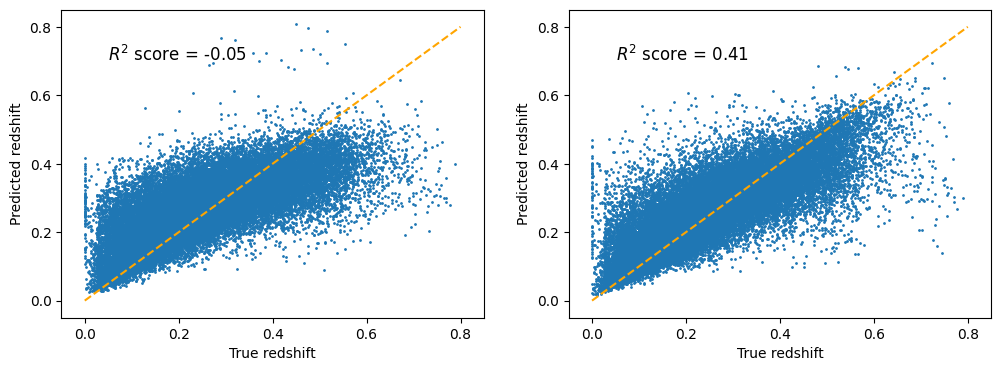

In [92]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plot_r2_score(ax[1], redshifts, ii_predicted_redshifts)
plot_r2_score(ax[0], redshifts, ii_pretrained_predicted_redshifts)

Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: 0.21
Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: -7.68


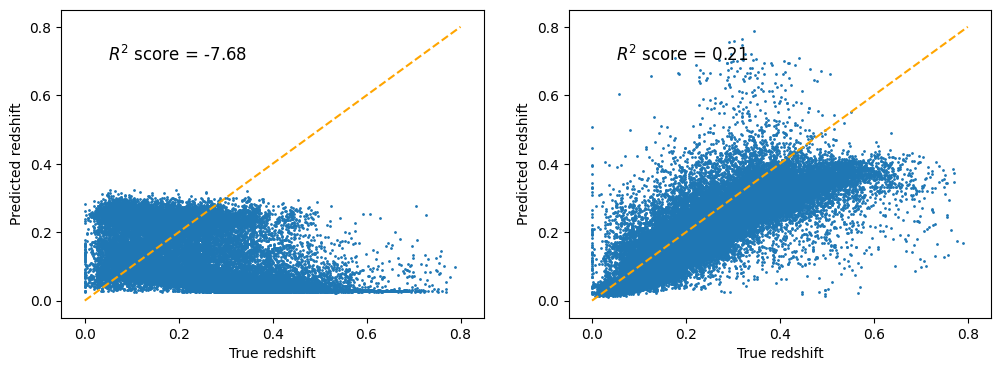

In [93]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plot_r2_score(ax[1], redshifts, si_predicted_redshifts)
plot_r2_score(ax[0], redshifts, si_pretrained_predicted_redshifts)

Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: -16.40
Outlier count: 374 (0.95%).
Total number of galaxies: 39,424
R² score: 0.00


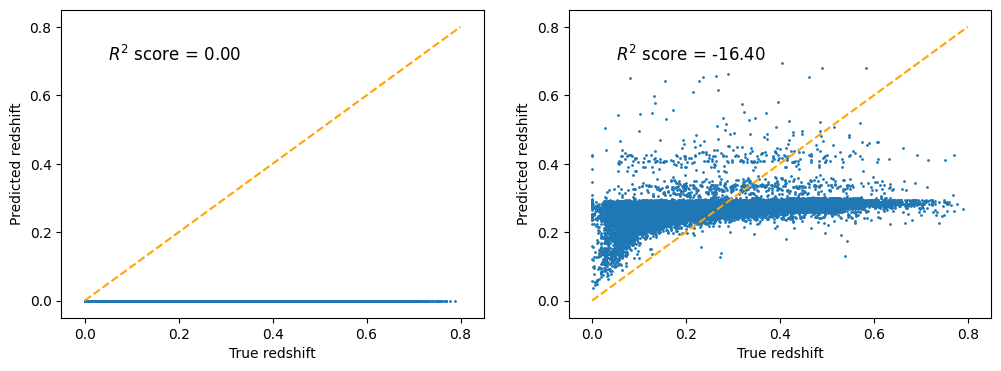

In [94]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plot_r2_score(ax[1], redshifts, is_predicted_redshifts)
plot_r2_score(ax[0], redshifts, is_pretrained_predicted_redshifts)